In [75]:
import torch
import torch.nn as nn
import numpy as np
from typing import List, Dict, Any
import json
import matplotlib.pyplot as plt


def vectorize_to_np(record_list: List[Dict[str, Any]], keys: List[str]) -> Dict[str, np.ndarray]:
    """Vectorizing record

    Args:
        record_list (List[Dict[str, Any]]): List of records, each record is a bundled dictionary
        keys (List[str]): keys to extract from records

    Returns:
        Dict[str, np.ndarray]: A dictionary in which keys are desired and values are numpy arrays
    """
    assert len(keys) > 0
    assert len(record_list) > 0
    res = {}
    for key in keys:
        res[key] = np.expand_dims(np.array([record[key] for record in record_list]),axis=-1)

    # Verify length
    _length: int = len(res[keys[0]])
    for key in keys:
        if _length != len(res[key]):
            raise ValueError("Not every attribute has the same length")

    return res
def solve_ellip(data: np.ndarray):
    class GravityModel(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.a = nn.Parameter(torch.ones(size=(1, )))
            self.b = nn.Parameter(torch.ones(size=(1, )))
            self.c = nn.Parameter(torch.ones(size=(1, )))
            self.x0 = nn.Parameter(torch.zeros(size=(1, )))
            self.y0 = nn.Parameter(torch.zeros(size=(1, )))
            self.z0 = nn.Parameter(torch.zeros(size=(1, )))

        def forward(self, vec):
            return ((vec[:, 0] - self.x0) / self.a)**2 + ((vec[:, 1] - self.y0) / self.b)**2 + ((vec[:, 2] - self.z0) / self.c) - 1
    net = GravityModel()
    net.train()
    optimizer = torch.optim.SGD(net.parameters(),lr=1e-4)
    data_tensor = torch.tensor(data)

    length = len(data)
    epoch_n = 4096
    batch_sz = 256
    for epoch_idx in range(epoch_n):
        idx = torch.randperm(data_tensor.nelement())
        data_tensor = data_tensor.view(-1)[idx].view(data_tensor.size())
        for batch_idx in range(length // batch_sz + 1):
            out = net(data_tensor[batch_idx * batch_sz:(batch_idx+1) * batch_sz])
            loss = torch.abs(torch.sum(out))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    return net.a.detach().cpu().numpy(), net.b.detach().cpu().numpy(), net.c.detach().cpu().numpy(), net.x0.detach().cpu().numpy(), net.y0.detach().cpu().numpy(), net.z0.detach().cpu().numpy()

Text(0.5, 1.0, 'ACCEL-Z')

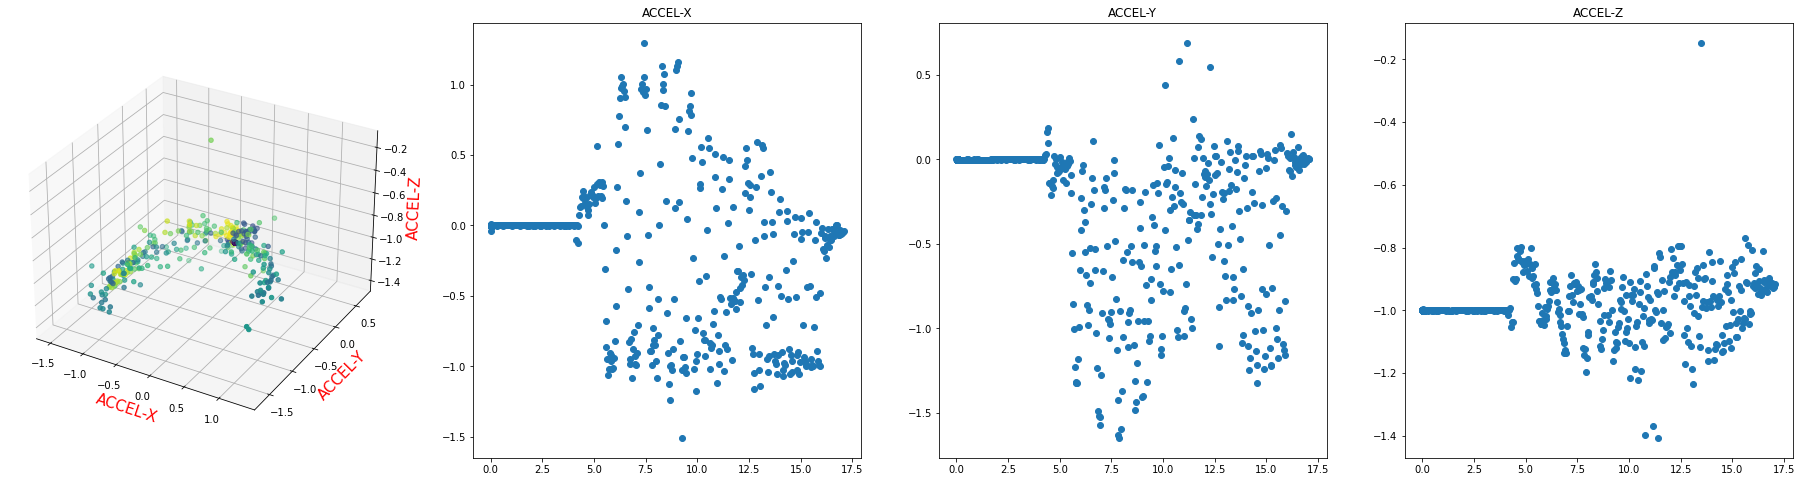

In [90]:
record_name = './data/2021-09-23/2021-09-23-19:03:18_cu.usbserial-13110_IMU_record.json' # path-like string
c = 1. / 180. * np.pi # deg->rad conversion

# use json module to load
record_list = json.load(open(record_name))
# record_list = record_list[100:]
x = vectorize_to_np(record_list,['accel_x','accel_y','accel_z', 'gyro_x', 'gyro_y','gyro_z','pitch','roll','yaw', 'time'])

accel = np.hstack([x['accel_x'],x['accel_y'],x['accel_z']])
gyro = np.hstack([x['gyro_x'],x['gyro_y'],x['gyro_z']])

fig = plt.figure(figsize=(32,8))
timestamp = x['time']

ax = fig.add_subplot(141, projection='3d')
ax.scatter(accel[:,0], accel[:,1], accel[:,2], c=timestamp)
ax.set_xlabel('ACCEL-X', fontdict={'size': 15, 'color': 'red'})
ax.set_ylabel('ACCEL-Y', fontdict={'size': 15, 'color': 'red'})
ax.set_zlabel('ACCEL-Z', fontdict={'size': 15, 'color': 'red'})


ax = fig.add_subplot(142)
ax.scatter(timestamp,accel[:,0])
ax.set_title('ACCEL-X')


ax = fig.add_subplot(143)
ax.scatter(timestamp,accel[:,1])
ax.set_title('ACCEL-Y')


ax = fig.add_subplot(144)
ax.scatter(timestamp,accel[:,2])
ax.set_title('ACCEL-Z')

In [86]:
solve_ellip(accel)

(array([1.6438426], dtype=float32),
 array([1.6206104], dtype=float32),
 array([2.2765138], dtype=float32),
 array([-0.48418513], dtype=float32),
 array([-0.48178735], dtype=float32),
 array([-2.2769022], dtype=float32))

In [88]:
accel_tot = 1 / np.sqrt(accel[:,0]**2 + accel[:,1]**2 + accel[:,2]**2)
accel_tot.max()

2.5330470292852425

In [92]:
gyro_tot = 1 / np.sqrt(gyro[:,0]**2 + gyro[:,1]**2 + gyro[:,2]**2)
gyro_tot

/var/folders/17/p7w_cbr51gj80vx_bvs6pmkh0000gn/T/ipykernel_12609/1995897974.py:1: RuntimeWarning: divide by zero encountered in true_divide
  gyro_tot = 1 / np.sqrt(gyro[:,0]**2 + gyro[:,1]**2 + gyro[:,2]**2)


array([1.24565245e+00, 3.57528191e+00, 7.32714755e+00, 1.15852375e+01,
       1.63840000e+01, 7.32714755e+00, 7.32714755e+00, 8.19200000e+00,
       7.32714755e+00, 1.15852375e+01, 3.04243242e+00, 3.57528191e+00,
       1.59891468e+00, 5.79261875e+00, 9.57163500e-01, 1.43361232e-01,
       1.48333766e+00, 3.97370368e+00, 7.32714755e+00, 1.15852375e+01,
       6.68873999e+00, 4.54410401e+00, 5.18107572e+00, 7.32714755e+00,
       4.54410401e+00, 4.93996187e+00, 1.15852375e+01, 4.93996187e+00,
       4.93996187e+00, 3.86174583e+00, 3.97370368e+00, 5.46133333e+00,
       4.93996187e+00, 5.46133333e+00, 4.93996187e+00, 5.46133333e+00,
       6.68873999e+00, 4.37880819e+00, 4.37880819e+00, 4.93996187e+00,
       3.86174583e+00, 4.54410401e+00, 4.37880819e+00, 5.18107572e+00,
       4.37880819e+00, 5.18107572e+00, 6.68873999e+00, 4.37880819e+00,
       5.18107572e+00, 9.45930681e+00, 3.86174583e+00, 3.97370368e+00,
       6.68873999e+00, 4.54410401e+00, 4.37880819e+00, 5.46133333e+00,
      

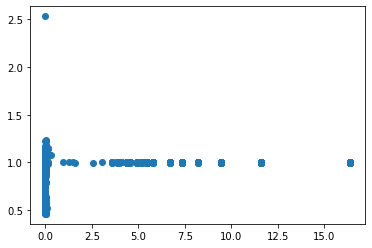

In [93]:
plt.scatter(gyro_tot, accel_tot)